## 목차

1. 프로젝트 개요  
 1.1. 문제 정의 및 목표  
 1.2. 데이터셋 설명  
 1.3. 평가 방법  

2. 환경 설정 및 데이터 준비  
 2.1. 환경 설정  
 2.2. 데이터 로드·전처리 및 클래스 확인  

3. cGAN 모델 설계  
 3.1. 모델 설계  
 3.2. Generator 구조 정의  
 3.3. Discriminator 구조 정의  

4. 학습 설정 및 cGAN 학습  
 4.1. 하이퍼파라미터, 손실 함수, 옵티마이저 설정  
 4.2. 학습 루프 구현  
 4.3. 학습 중 생성 이미지 시각화  

5. 결과 분석  
 5.1. 평가 결과 분석  
 5.2. 한계점 및 개선 방향

## 1. 프로젝트 개요

### 1.1. 문제 정의 및 목표

- 이 프로젝트는 FashionMNIST 데이터셋을 활용하여, 각 패션 아이템 클래스(티셔츠, 바지, 드레스, 스니커즈 등)에 대해 조건부 이미지 생성이 가능한 Conditional GAN(cGAN) 모델을 구현하는 것을 목표로 한다.

- 잠재 벡터 $z$ 와 클래스 레이블을 함께 입력으로 사용하는 Generator를 설계하고, 특정 레이블(예: “Sneaker”, “Bag”)을 지정했을 때 해당 클래스에 해당하는 이미지를 생성하도록 학습시킨다.

- 학습된 모델의 생성 이미지를 시각적으로 평가하고, FID / IS 등 정량 지표를 참고하여 모델의 성능과 한계점을 분석한다.

### 1.2. 데이터셋 설명

- 데이터셋: Fashion-MNIST
- 구성
    - 이미지 크기: 28 ×28
    - 색상 채널: 흑백(grayscale)
    - 클래스 수: 총 10개
    - 학습 데이터: 60,000장
    - 테스트 데이터: 10,000장

| 클래스 번호 | 클래스 이름      |
|:-----------|:----------------|
| 0          | T-shirt/top     |
| 1          | Trouser         |
| 2          | Pullover        |
| 3          | Dress           |
| 4          | Coat            |
| 5          | Sandal          |
| 6          | Shirt           |
| 7          | Sneaker         |
| 8          | Bag             |
| 9          | Ankle boot      |

### 1.3. 평가 방법 

- 정성적 평가
    - 학습 과정 중 및 학습 종료 후, 각 클래스 레이블(0~9)에 대해 이미지를 생성하고 그리드 형태로 시각화

    - 클래스별로 형태가 잘 구분되는지, 노이즈에 따라 다양한 스타일이 나오는지 확인

- 정량적 평가
    - GAN 이미지 품질 비교에 널리 사용하는 지표인 FID(Fréchet Inception Distance) 또는 IS(Inception Score)를 참고하여 성능을 수치로 비교

| 지표                                   | 의미                                    | 특징                                        |
| ------------------------------------ | ------------------------------------- | ----------------------------------------- |
| **FID (Fréchet Inception Distance)** | 생성 이미지 분포와 실제 이미지 분포의 차이 측정          | 낮을수록 실제와 비슷한 이미지, 데이터 분포까지 고려             |
| **IS (Inception Score)**             | 생성 이미지가 얼마나 다양하고 명확하게 특정 클래스에 속하는지 평가 | 높을수록 클래스 구분이 뚜렷하고 다양성이 높음, 분포 전체는 고려하지 않음 |


## 2. 환경 설정 및 데이터 준비

### 2.1. 환경 설정

- 필수 라이브러리 임포트
- GPU 사용 가능 여부에 따라 device 설정

In [1]:
# 필수 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 연산 장치 설정 (GPU 사용 가능 시 cuda, 아니면 cpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### 2.2. 데이터 로드·전처리 및 클래스 확인

- torchvision의 FashionMNIST를 사용해 train/test 데이터를 ./data 아래 다운로드

- 이미지는 Tensor로 변환 후, cGAN 출력 범위와 맞추기 위해 [-1, 1]로 정규화

- 이후 학습에 사용할 DataLoader와 클래스 이름 매핑 준비

In [3]:
# Transform 정의: Tensor 변환 + [-1, 1] 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# FashionMNIST train/test 데이터셋 로드 (./data/FashionMNIST 경로 자동 생성)
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# DataLoader 정의
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# 클래스 인덱스 → 이름 매핑 (10개 전체 사용)
idx_to_class = {i: class_name for i, class_name in enumerate(train_dataset.classes)}
idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## 3. cGAN 모델 설계

### 3.1. 모델 설계

- GAN: Generator는 단순히 노이즈 벡터 $z$ 만 받아 “아무 클래스나” 이미지를 생성 → 어떤 클래스가 나올지 통제 불가

- cGAN:Generator와 Discriminator 둘 다에 레이블 $y$ 를 함께 입력으로 주어, “7번(Sneaker) 이미지를 만들어라” 등과 같이 원하는 클래스를 직접 지정할 수 있음

- 모델 설계
    - Generator: noise(z) + label embedding을 concat해서 입력으로 사용

    - Discriminator: image + label map을 채널 방향으로 concat해서 real/fake 판별

In [4]:
# 전역 하이퍼파라미터 설정
image_size = 28      # FashionMNIST 이미지 크기
num_classes = 10     # 클래스 수 (0~9)
latent_dim = 100     # 잠재 벡터 차원

### 3.2. Generator 구조 정의

- 과정
    - noise와 label_emb를 concat → FC로 128×7×7 feature map 생성
    - Upsample + Conv 블록 2번으로 28×28까지 업샘플링
    - 마지막에 Tanh로 [-1, 1] 범위 이미지 출력

- 입력
    - 잠재 벡터 noise (batch_size × 100)
    - 레이블 labels (정수 0~9) → Embedding → one-hot 비슷한 10차원 벡터

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # 레이블 임베딩 (num_classes 차원)
        self.label_emb = nn.Embedding(num_classes, num_classes)

        self.init_size = image_size // 4  # 28 // 4 = 7
        self.l1 = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 128 * self.init_size * self.init_size),
            nn.ReLU(inplace=True)
        )

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),  # 7 -> 14
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),  # 14 -> 28
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # 출력 범위 [-1, 1]
        )

    def forward(self, noise, labels):
        # labels: (B,) → (B, num_classes)
        label_input = self.label_emb(labels)
        # 노이즈와 레이블 임베딩 결합
        gen_input = torch.cat((noise, label_input), dim=-1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

### 3.3. Discriminator 구조 정의

- 과정
    - 이미지 채널(1)과 레이블 채널(1)을 concat → (B, 2, 28, 28)
    - Conv → Conv → Flatten → Linear → Sigmoid 로 real/fake 판별 확률 출력

- 입력
    - 이미지 img (B × 1 × 28 × 28)
    - 레이블 labels (정수 0~9) → Embedding → (B, 1, 28, 28)로 복제

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # 레이블을 스칼라 채널로 임베딩
        self.label_emb = nn.Embedding(num_classes, 1)

        self.model = nn.Sequential(
            # 이미지(1ch) + 레이블(1ch) = 2채널 입력
            nn.Conv2d(2, 64, kernel_size=3, stride=2, padding=1),  # 28 -> 14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 14 -> 7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten(),
            nn.Linear(128 * (image_size // 4) * (image_size // 4), 1),  # 128*7*7
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        # 레이블 임베딩 후 이미지 크기로 확장
        label = self.label_emb(labels)              # (B, 1)
        label = label.view(batch_size, 1, 1, 1)     # (B, 1, 1, 1)
        label = label.expand(batch_size, 1, image_size, image_size)  # (B, 1, 28, 28)

        # 이미지와 레이블 채널 결합
        d_in = torch.cat((img, label), dim=1)  # (B, 2, 28, 28)
        validity = self.model(d_in)           # (B, 1)
        return validity

## 4. 학습 설정 및 cGAN 학습

### 4.1. 하이퍼파라미터, 손실 함수, 옵티마이저 설정

- BCE 손실로 real/fake 구분 학습
- Adam 옵티마이저 사용

In [7]:
# 모델 초기화
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# 학습 설정
epochs = 30
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

### 4.2. 학습 루프 구현

- D/G 학습 순서 지정, loss 출력
- D: real(img, label) → 1, fake(G(z, label), label) → 0
- G: fake(G(z, label), label)을 D가 1로 보게 만들기

In [8]:
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        batch_size_current = imgs.size(0)
        imgs = imgs.to(device)
        labels = labels.to(device)

        valid = torch.ones(batch_size_current, 1, device=device)
        fake  = torch.zeros(batch_size_current, 1, device=device)

        # 1) 판별자 학습
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(imgs, labels), valid)

        noise = torch.randn(batch_size_current, latent_dim, device=device)
        gen_labels = labels
        gen_imgs = generator(noise, gen_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach(), labels), fake)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # 2) 생성자 학습
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs, labels), valid)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  D_loss: {d_loss.item():.4f}  G_loss: {g_loss.item():.4f}")

Epoch [1/30]  D_loss: 0.8476  G_loss: 1.0620
Epoch [2/30]  D_loss: 1.0902  G_loss: 1.0228
Epoch [3/30]  D_loss: 1.1002  G_loss: 1.1700
Epoch [4/30]  D_loss: 1.1544  G_loss: 1.2089
Epoch [5/30]  D_loss: 1.1535  G_loss: 1.2049
Epoch [6/30]  D_loss: 0.9890  G_loss: 1.4074
Epoch [7/30]  D_loss: 1.2161  G_loss: 0.9818
Epoch [8/30]  D_loss: 1.0771  G_loss: 1.4222
Epoch [9/30]  D_loss: 1.1459  G_loss: 0.9902
Epoch [10/30]  D_loss: 1.0397  G_loss: 0.8427
Epoch [11/30]  D_loss: 1.1053  G_loss: 1.5019
Epoch [12/30]  D_loss: 1.0089  G_loss: 1.4263
Epoch [13/30]  D_loss: 1.1559  G_loss: 1.1149
Epoch [14/30]  D_loss: 0.9704  G_loss: 1.3228
Epoch [15/30]  D_loss: 0.8628  G_loss: 1.4140
Epoch [16/30]  D_loss: 0.9780  G_loss: 1.7893
Epoch [17/30]  D_loss: 0.9881  G_loss: 2.0183
Epoch [18/30]  D_loss: 0.9707  G_loss: 1.8176
Epoch [19/30]  D_loss: 0.7650  G_loss: 1.5614
Epoch [20/30]  D_loss: 0.9070  G_loss: 1.6771
Epoch [21/30]  D_loss: 0.9585  G_loss: 1.9672
Epoch [22/30]  D_loss: 0.8988  G_loss: 1.78

### 4.3. 학습 중 생성 이미지 시각화

**정성 평가**

- 일정 epoch마다: 0~9 클래스 각각에 대해 여러 샘플 생성해 그리드로 확인

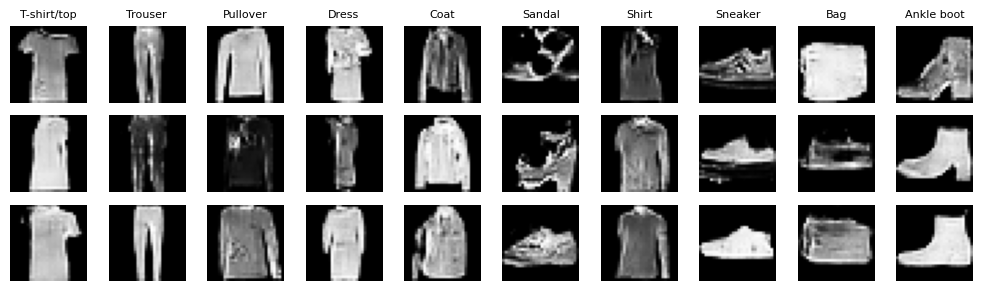

In [9]:
    # 10 에포크마다 클래스별 생성 이미지 시각화
    if (epoch + 1) % 10 == 0:
        generator.eval()
        n_row = 3               # 각 클래스당 3개씩
        n_col = num_classes     # 10개 클래스
        total_samples = n_row * n_col

        noise = torch.randn(total_samples, latent_dim, device=device)
        labels_sample = torch.arange(0, num_classes, device=device).repeat(n_row)
        gen_imgs = generator(noise, labels_sample).detach().cpu()

        fig, axs = plt.subplots(n_row, n_col, figsize=(n_col, n_row))
        for i in range(n_row):
            for j in range(n_col):
                idx = i * n_col + j
                axs[i, j].imshow(gen_imgs[idx, 0, :, :], cmap='gray')
                axs[i, j].axis('off')
                if i == 0:
                    axs[i, j].set_title(idx_to_class[j], fontsize=8)
        plt.tight_layout()
        plt.show()
        generator.train()

**정량 평가**

- FID / IS 계산 시에는 Inception 기반 모델을 사용하므로, FashionMNIST 원본 이미지 형태 그대로는 사용할 수 없다.

- 이를 위해 `preprocess_images_for_fid()` 함수에서 다음과 같은 변환을 수행한다.

1. **값 범위 변환 및 dtype 변경**
   - 학습에 사용된 이미지는 `[-1, 1]` 범위의 `float` 텐서이므로,  
     ```[-1, 1] → [0, 255]

   - 이는 FID 구현체(내부 torch-fidelity)가 **0~255 범위의 `torch.uint8` 이미지**를 입력으로 요구하기 때문이다.

2. **채널 수 확장 (1채널 → 3채널)**
   - FashionMNIST는 흑백(1채널)이지만, Inception 모델은 일반적으로 RGB(3채널) 입력을 가정한다.

   - 따라서 `images.repeat(1, 3, 1, 1)` 연산을 통해 1채널을 3번 복제하여 **[N, 3, H, W]** 형태로 맞춘다.

3. **해상도 변환 (28×28 → 299×299)**
   - InceptionV3는 기본적으로 299×299 크기의 입력을 사용하므로,  
     `F.interpolate(..., size=(299, 299))`로 해상도를 업샘플링한다.

   - 업샘플링 과정에서 다시 `float` 타입이 되므로, 마지막에 한 번 더 `[0, 255]` 범위로 클램프하고 `uint8`로 변환한다.

4. **real / fake 공통 전처리**
   - `real_images`와 `fake_images` 모두 위 전처리 함수를 거쳐 **동일한 전처리 파이프라인**을 적용한 후,  
     `FrechetInceptionDistance`와 `InceptionScore`에 입력으로 사용한다.

   - 이렇게 해야 **real 분포와 fake 분포가 공정하게 비교**되며, FID / IS 값이 의미를 갖게 된다.

In [24]:
import torch
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore

def preprocess_images_for_fid(images):
    images = (images + 1) * 127.5
    images = images.clamp(0, 255).to(torch.uint8)
    images = images.repeat(1, 3, 1, 1)  # 1채널 -> 3채널 복제
    images = F.interpolate(images.float(), size=(299, 299), mode='bilinear', align_corners=False)
    images = images.clamp(0, 255).to(torch.uint8)
    return images

# 1) real_images 1000장 샘플링
real_samples = []
real_labels = []
for imgs, labels in test_loader:
    real_samples.append(imgs)
    real_labels.append(labels)
    if len(real_samples)*imgs.size(0) >= 1000:
        break
real_images = torch.cat(real_samples, dim=0)[:1000].cpu()

# 2) fake_images 생성
device = next(generator.parameters()).device
noise = torch.randn(1000, latent_dim, device=device)
fake_labels = torch.cat(real_labels, dim=0)[:1000].to(device)
generator.eval()
with torch.no_grad():
    fake_images = generator(noise, fake_labels).cpu()
generator.train()

# 3) 전처리
real_images_pre = preprocess_images_for_fid(real_images)
fake_images_pre = preprocess_images_for_fid(fake_images)

# 4) 메트릭 초기화 (CPU)
fid_metric = FrechetInceptionDistance().to('cpu')
is_metric = InceptionScore().to('cpu')

# 5) 배치 단위 업데이트 (배치 100)
batch_size = 100
for i in range(0, real_images_pre.size(0), batch_size):
    end_idx = min(i + batch_size, real_images_pre.size(0))
    fid_metric.update(real_images_pre[i:end_idx], real=True)
    fid_metric.update(fake_images_pre[i:end_idx], real=False)

fid_score = fid_metric.compute().item()
print(f"FID Score: {fid_score:.4f}")

# 6) IS 계산
is_score, is_std = is_metric(fake_images_pre)
print(f"Inception Score: {is_score:.4f} ± {is_std:.4f}")

FID Score: 41.7307
Inception Score: 3.7591 ± 0.2859


## 5. 결과 분석

### 5.1. 평가 결과 분석

**정성 평가(시각적 분석) 결과**

- 10, 20, 30 에포크별 생성된 이미지들을 통해 확인한 바, 티셔츠, 바지, 가방, 신발 등 대부분 클래스에서 형태가 뚜렷하게 구분됨

- 초기 에포크(10)에서는 흐릿한 패턴이 많았으나, 후반부(30 에포크)로 갈수록 실제 FashionMNIST 이미지와 유사한 윤곽이 형성됨

- 일부 클래스(Pullover, Coat 등)에서 여전히 모호한 패턴이 관찰되나, 대다수 클래스에서 조건부 생성 성공을 확인하였음

**정량 평가(지표 분석) 결과**

- FID Score: 41.7307
    - ```FID Score``` 는 낮을수록 좋음. FashionMNIST cGAN 기준 30~60 범위는 중간 수준의 현실성을 나타냄.

    - 테스트셋 1000장과 동일 조건 생성 이미지 1000장 비교 결과로, 실제 이미지 분포와 중간 수준의 유사성을 보임.

- Inception Score: 3.7591 ± 0.2859
    - ```Inception Score``` 는 높을수록 좋음. 3~5 범위는 적당한 품질과 다양성을 나타냄.

    - 생성 이미지들이 너무 단순하지 않고 적절한 다양성을 가지며, Inception 분류기 기준으로 명확한 클래스 특징을 포함함을 확인하였음.

### 5.2. 한계점 및 개선 방향

**한계점**

- 일부 클래스 형태 혼동: Pullover, Coat, Shirt 등 유사한 형태의 클래스에서 생성 이미지 구분이 모호함

- FID 40대 수준: 실제 FashionMNIST 분포와의 거리가 여전히 존재 (목표: 20~30대)

- IS 3.7 수준: 생성 이미지 다양성이 제한적 (목표: 5.0+)

- 학습 안정성: D_loss, G_loss 변동폭이 크고 mode collapse 위험 존재

**개선 방향**

1. 학습 epoch 30 → 100 증가 (수렴 확인)

2. 데이터 증강: RandomRotation(±10°), RandomCrop 적용

3. 학습률 스케줄링: CosineAnnealingLR 도입

4. 배치 크기 증가: 64 → 128